In [1]:
import numpy as np
from casadi import *
import casadi as cs
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter
import sympy as sym
from IPython.display import display, Math


In [2]:
from decentralized import util

In [3]:
%load_ext autoreload
%autoreload 2

## An example of using Casadi to optimize trajectory for a Human (modelled with a unicycle):

In [4]:
Δt = sym.Symbol('\Delta t')
sθ = sym.Symbol('\sin \Theta')
cθ = sym.Symbol('\cos \Theta')
p_x, p_y, p_z, v, omega, theta, a = sym.symbols('p_x p_y p_z v omega theta a')

x = sym.Matrix([p_x, p_y, p_z, v])
u = sym.Matrix([theta, a])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [5]:
x0 = np.array([0, 0, 1.7, 0.05, 0, 0])
xf = np.array([1.5,1.5,1.7,0, 0, 0])

Q = np.eye(6)*5
R = np.eye(2)*0.1
Qf = np.eye(6)*100

u_ref = np.array([0,0])

N = 100

opti = Opti()

dt = 0.05

In [6]:
X = opti.variable(6,N+1)
U = opti.variable(2,N)

In [7]:
f = lambda x,u: vertcat(x[3]*cos(u[0]),x[3]*sin(u[0]),0,u[1], 0, 0)

In [8]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps

In [9]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [10]:
objective = total_terminal_cost + total_stage_cost

In [11]:
opti.minimize(objective) 

In [59]:
opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(X[3,:]<=5) # v is limited
opti.subject_to(-5<=X[3,:])

opti.subject_to(U[0,:]<=np.pi/2) # theta is limited
opti.subject_to(-np.pi/2<=U[0,:])

opti.subject_to(U[1,:]<=1) # a is limited
opti.subject_to(-1<=U[1,:]) 

#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver('ipopt');
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')
X_trj = sol.value(X)
U_trj = sol.value(U)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1906
Number of nonzeros in inequality constraint Jacobian.:     1006
Number of nonzeros in Lagrangian Hessian.............:     1005

Total number of variables............................:      806
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:     1006
        inequality constraints with only lower bounds:      503
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      503

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4340000e+03 1.70e+00 2.67e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Text(0.5, 0.92, 'Trajectory from one-shot optimization (human)')

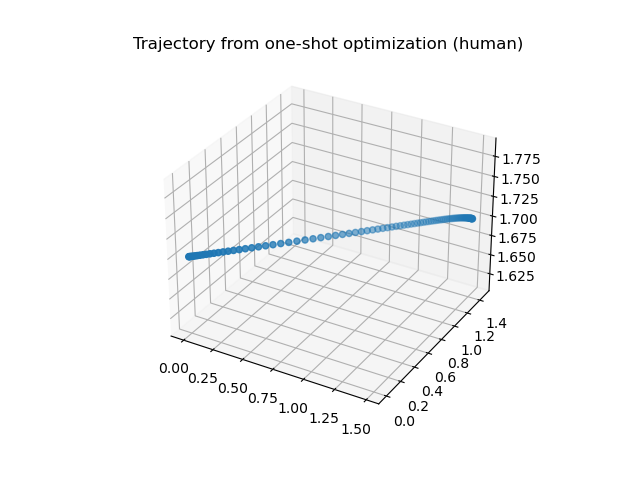

In [60]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization (human)')


## Running inhomogenous test with 2 quadrotors and 1 human (receding-horizon):

In [204]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]-1):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [251]:
def generate_f_human_drone(x_dims_local,n_human):
    g = 9.8
    # NOTE: Assume homogeneity of agents.
    n_agents = len(x_dims_local)
    n_states = x_dims_local[0]
    n_controls = 3
    
    def f(x, u):
        x_dot = cs.MX.zeros(x.numel())
        for i_agent in range(0,n_agents-n_human):
            i_xstart = i_agent * n_states
            i_ustart = i_agent * n_controls
            x_dot[i_xstart:i_xstart + n_states] = cs.vertcat(
                x[i_xstart + 3: i_xstart + 6],
                g*cs.tan(u[i_ustart]), -g*cs.tan(u[i_ustart+1]), u[i_ustart+2] - g
                )
        count = 0
        for j_agent in range(n_agents-n_human,n_agents):
            j_xstart = j_agent * n_states
            j_ustart = j_agent * n_controls #human agent has 2 control var.
            if count > 0:
                j_ustart -=1
            count +=1
            
            x_dot[j_xstart:j_xstart + n_states] = cs.vertcat(
                x[j_xstart + 3]*cs.cos(u[j_ustart]), x[j_xstart+3]*cs.sin(u[j_ustart]),0,
                u[j_ustart+1], 0 , 0
                )
            
        return x_dot
    
    return f

In [252]:
count = 0
for j_agent in range(3,5):
    j_xstart = j_agent * 6
    j_ustart = j_agent * 3 #human agent has 2 control var.
    if count > 0:
        j_ustart -=1
    count+=1
    print(j_xstart,j_ustart,j_ustart+1)

18 9 10
24 11 12


In [253]:
#2 drones + 1 human:
n_agents = 3
n_humans = 1
n_states = 6
n_inputs = 3
n_dims = [3,3,2]
x_dims = [6,6,6]
u_dims = [3,3,2]

x0 = np.array([[0.5, 1.5, 1.5, 0, 0, 0,   #Drone
               2.5, 1.5, 1.5, 0, 0, 0,   #Drone
               1, 1, 1.7, 0.01, 0, 0]]).T #Human 

xf = np.array([[ 2.5, 1.5, 1.5, 0, 0, 0, 
                0.5, 1.5, 1.5, 0, 0, 0,
                2, 2, 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0])

dt = 0.1

In [207]:

# f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g,
#                     x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
#                     x[15]*cos(u[6]), x[15]*sin(u[6]), 0, u[7], 0, 0)
f = generate_f_human_drone(x_dims,n_humans)

In [210]:
theta_max = np.pi / 6
phi_max = np.pi / 6

v_max = 3
v_min = -3

theta_min = -np.pi / 6
phi_min = -np.pi / 6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.5

max_input_base = np.array([[theta_max], [phi_max], [tau_max]])
min_input_base = np.array([[theta_min], [phi_min], [tau_min]])
max_state_base = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
min_state_base = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])




# max_input_human = np.array([np.pi/2,2])
# min_input_human = np.array([-np.pi/2,-2])

# max_state_human = np.array([x_max,y_max,z_max,v_max,0,0])
# min_state_human = np.array([x_min,y_min,z_min,v_min,0,0])

In [211]:
#actually it makes no sense to put constraints on the human agent; 
#human agent is assumed to be irrational

In [212]:
radius = 0.5

In [213]:
#Setting up constraints for the drones:
max_input = np.tile(max_input_base,(n_agents-n_humans,1))
min_input = np.tile(min_input_base,(n_agents-n_humans,1))
max_state = np.tile(max_state_base,(n_agents-n_humans,1))
min_state = np.tile(min_state_base,(n_agents-n_humans,1))

In [267]:
def solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,d_threshold,n_dims,u_dims):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 1000,"print_level":0}
    
    
    M = 200 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    # n_u = n_agents*n_inputs
    n_u = sum(u_dims)
    x_dims = [n_states]*n_agents
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    dt = 0.1
    
    while np.any(distance_to_goal(x0,xf,n_agents,n_states) > 0.1)  and (i < M):
        
        
        opti = Opti()
        
        X = opti.variable(n_x,N+1)
        U = opti.variable(n_u,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)

        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps
    
            opti.subject_to(U[0:(n_agents-n_humans)*n_inputs,k] <= max_input)
            opti.subject_to(min_input <= U[0:(n_agents-n_humans)*n_inputs,k])
   
        #collision avoidance constraints
        for k in range(N+1):
            distances = compute_pairwise_distance_nd_Sym(X[:,k], x_dims,n_dims)
            opti.subject_to(X[0:(n_agents-n_humans)*n_states,k] <= max_state)
            opti.subject_to(min_state <= X[0:(n_agents-n_humans)*n_states,k])

            for n in range(len(distances)):
                opti.subject_to(distances[n] >= radius)
    
        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)
        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        sol = opti.solve()
        # print(opti.debug.value)
        x0 = sol.value(X)[:,1].reshape(-1,1)
        # print(x0.shape)
        u_sol = sol.value(U)[:,0]
        
        J_list.append(sol.value(cost_fun))
        print(f'current objective function value is {sol.value(cost_fun)}')
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        # print(opti.variable) #print this to check the optimization parameters for each control horizon
        
        if abs(J_list[i]-J_list[i-1]) <= 1.0 :
            print(f'Terminated! at i = {i}')
            break
            
        
    return X_full,U_full, t

In [215]:
#equality constraints:
N = 15
t0 = perf_counter()
n_agents = 3
n_states = 6
X_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,radius,n_dims,u_dims)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 568.00us (  7.28us)        78
       nlp_g  |        0 (       0)   1.57ms ( 20.09us)        78
  nlp_grad_f  |        0 (       0) 738.10us (  9.46us)        78
  nlp_hess_l  |        0 (       0)   2.11ms ( 27.76us)        76
   nlp_jac_g  |        0 (       0)   2.38ms ( 30.54us)        78
       total  | 453.12ms (453.12ms) 459.74ms (459.74ms)         1
current objective function value is 1228.6840553437926
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 236.50us (  7.39us)        32
       nlp_g  |        0 (       0) 649.00us ( 20.28us)        32
  nlp_grad_f  |        0 (       0) 313.20us (  9.49us)        33
  nlp_hess_l  |        0 (       0) 886.70us ( 28.60us)        31
   nlp_jac_g  |        0 (       0)   1.05ms ( 31.82us)        33
       total  | 171.88ms (171.88ms) 178.85ms (178.85ms)         1
current objective fun

In [216]:
X_trj.shape

(31, 18)

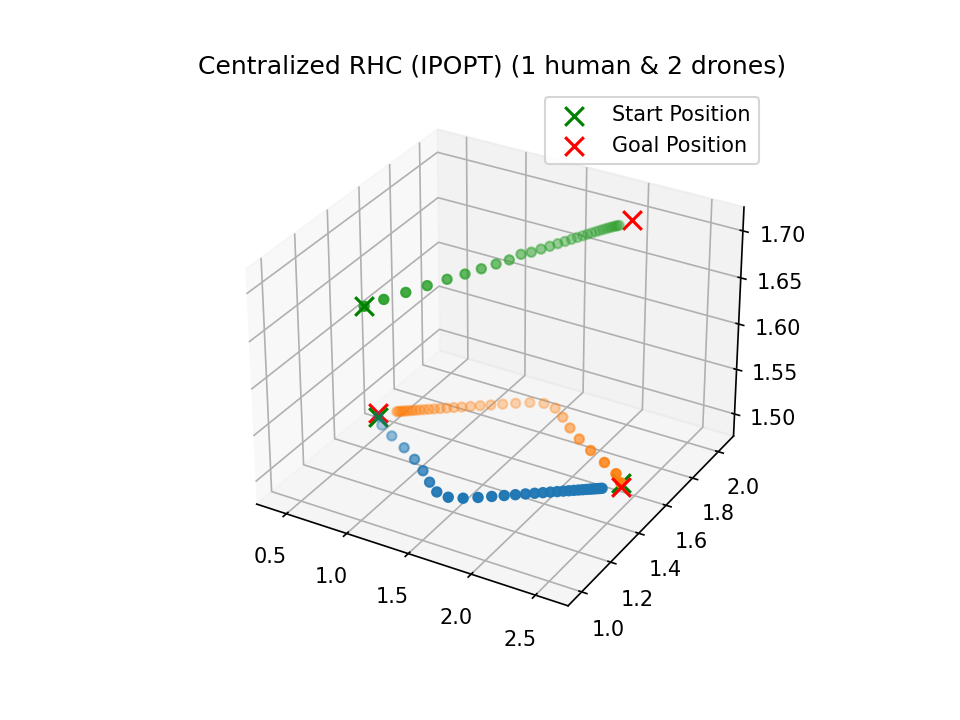

In [217]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_trj,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Centralized RHC (IPOPT) (1 human & 2 drones)')
plt.savefig('results/one_human_2_drones.png')

In [218]:
X_trj[-1,:].shape

(18,)

In [219]:
np.linalg.norm(X_trj[-1,:]-xf.flatten()) #final state error

0.2504050849894041

In [220]:
X_trj.shape

(31, 18)

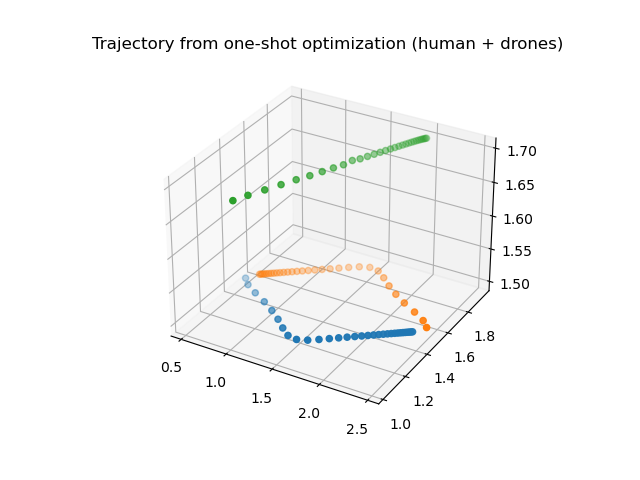

In [221]:
#animate the plot:
import matplotlib.animation as animation

# First, create a function that updates the scatter plot for each frame
def update_plot(n,X_trj,scatters):
    # Set the data for each scatter plot
    scatters[0].set_offsets(np.stack((X_trj[:n , 0], X_trj[:n, 1], X_trj[:n, 2]), axis=1))
    scatters[1].set_offsets(np.stack((X_trj[:n ,6], X_trj[:n, 7], X_trj[:n, 8]), axis=1))
    scatters[2].set_offsets(np.stack((X_trj[:n, 12], X_trj[:n, 13], X_trj[:n, 14]), axis=1))
    return scatters


# Create the figure and axis
fig = plt.figure()
ax = plt.axes(projection='3d')

# Create the scatter plots
scatters = []
scatters.append(ax.scatter(X_trj[:,0], X_trj[:,1], X_trj[:,2]))
scatters.append(ax.scatter(X_trj[:,6], X_trj[:,7], X_trj[:,8]))
scatters.append(ax.scatter(X_trj[:,12], X_trj[:,13], X_trj[:,14]))

# Set the title
ax.set_title('Trajectory from one-shot optimization (human + drones)')

ani = animation.FuncAnimation(fig, update_plot, frames=range(X_trj.shape[1]), fargs=(X_trj, scatters))

plt.show()

In [169]:
# ani.save('animation.mp4')

AxisError: axis 1 is out of bounds for array of dimension 1

## Running inhomogenous test with 3 quadrotors and 2 human (receding-horizon):

In [149]:
paper_setup_3_quads()[1].T

array([[2.5, 1.5, 1. , 0. , 0. , 0. , 0.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
        2.2, 1. , 0. , 0. , 0. ]])

In [258]:
#3 drones + 2 human:
n_agents = 5
n_states = 6
n_humans = 2
n_dims = [3,3,3,2,2]
x_dims = [6,6,6,6,6]
u_dims = [3,3,3,2,2]

x0 = np.array([[0.5, 1.5, 1. , 0. , 0. , 0. ,   #Drone
               2.5, 1.5, 1. , 0. , 0. , 0.,   #Drone
              1.5, 1.3, 1. , 0. , 0. , 0.,  #Drone
              1, 1, 1.7, 0.01, 0, 0 , #Human 1
              2.1, 2.1, 1.7, -0.01, 0, 0]]).T # Human 2

xf = np.array([[ 2.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                0.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                1.5, 2.2, 1. , 0. , 0. , 0. , #Drone
                2., 2., 1.7, 0,  0,  0,  
                1., 1., 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,0,0])


opti = Opti()

dt = 0.05

In [259]:
x_dims

[6, 6, 6, 6, 6]

In [260]:
f = generate_f_human_drone(x_dims,n_humans)

In [261]:
max_input = np.tile(max_input_base,(n_agents-n_humans,1))
min_input = np.tile(min_input_base,(n_agents-n_humans,1))
max_state = np.tile(max_state_base,(n_agents-n_humans,1))
min_state = np.tile(min_state_base,(n_agents-n_humans,1))

In [262]:
u_dims

[3, 3, 3, 2, 2]

In [263]:
sum(u_dims)

13

In [271]:
radius = 0.5
N = 15
t0 = perf_counter()
X_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,radius,n_dims,u_dims)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 989.00us ( 10.87us)        91
       nlp_g  |  93.75ms (  1.03ms)   2.99ms ( 32.84us)        91
  nlp_grad_f  |        0 (       0)   1.35ms ( 15.02us)        90
  nlp_hess_l  |        0 (       0)   5.04ms ( 57.32us)        88
   nlp_jac_g  |        0 (       0)   4.95ms ( 54.97us)        90
       total  |   5.42 s (  5.42 s) 900.11ms (900.11ms)         1
current objective function value is 1562.8799983082858
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 616.00us ( 10.81us)        57
       nlp_g  |        0 (       0)   1.82ms ( 32.00us)        57
  nlp_grad_f  |        0 (       0) 860.00us ( 14.83us)        58
  nlp_hess_l  |        0 (       0)   3.13ms ( 55.81us)        56
   nlp_jac_g  |  93.75ms (  1.62ms)   3.20ms ( 55.15us)        58
       total  |   2.98 s (  2.98 s) 505.48ms (505.48ms)         1
current objective fun

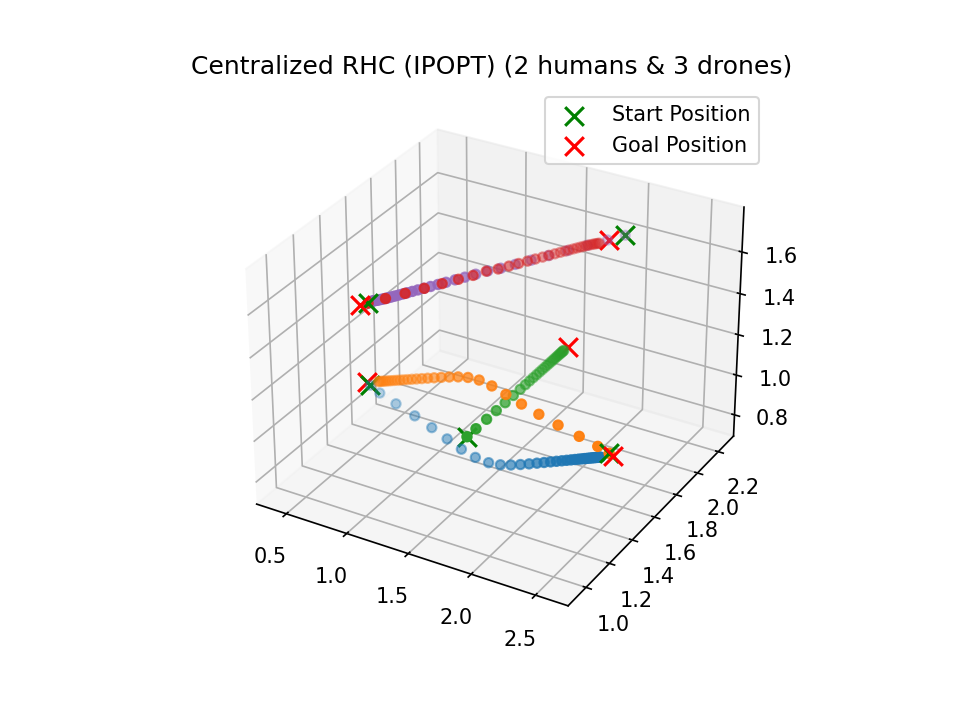

In [273]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_trj,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Centralized RHC (IPOPT) (2 humans & 3 drones)')
plt.savefig('results/two_human_3_drones.png')